In [2]:

import pandas as pd
from zoneinfo import ZoneInfo

import mplfinance as mpf
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
import sys
from pathlib import Path

project_dir = Path().resolve().parent
sys.path.append(str(project_dir))

# import my own modules
from CommonFunc.db_handler import DbHandler
from CommonFunc.fetch_update import FetcherUpdater

#### 0. Getting Data and Process Date Columns

In [14]:
# using absolute db path
db = DbHandler("D:\个人文件\个人发展\Git Projects\crypto-analysis\Data\crypto.db")
fetch_update = FetcherUpdater("D:\个人文件\个人发展\Git Projects\crypto-analysis\Data\crypto.db")

update_df = fetch_update.add_price_data(crypto='BTC', table='btc_hourly')
print(update_df)

Data is already up-to-date.
None


In [15]:
# save to db if there's updated data
if not update_df.empty:
    db.save_to_db(update_df, 'btc_hourly')
    print('Updated data saved to db')
else:
    print('Data is up-to-date')

AttributeError: 'NoneType' object has no attribute 'empty'

In [7]:
# query btc price data
query = "SELECT * FROM btc_hourly order by time" # contains btc hourly data from 2014
df = db.read_from_db(query)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90868 entries, 0 to 90867
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        90868 non-null  int64  
 1   utc_dt      90868 non-null  object 
 2   nyc_dt      90868 non-null  object 
 3   high        90868 non-null  float64
 4   low         90868 non-null  float64
 5   open        90868 non-null  float64
 6   close       90868 non-null  float64
 7   volumefrom  90868 non-null  float64
 8   volumeto    90868 non-null  float64
 9   avg         90868 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 6.9+ MB
None


In [8]:
df['utc_dt'] = pd.to_datetime(df['utc_dt'])
df['nyc_dt'] = df['utc_dt'].apply(lambda x: x.astimezone(ZoneInfo("America/New_York")))

#### 1. Compute Technical Metrics

In [9]:
# 1. SMA: simple moving average
df['sma_24'] = df['close'].rolling(window=24).mean()  # 24-hour SMA
df['sma_72'] = df['close'].rolling(window=72).mean()  # 3-day SMA

# EMA: exponential moving average
df['ema_24'] = df['close'].ewm(span=24, adjust=False).mean()
df['ema_72'] = df['close'].ewm(span=72, adjust=False).mean()

# 2. RSI: Relative Strength Index
window = 14
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
rs = gain / loss
df['rsi'] = 100 - (100 / (1 + rs))

# 3. MACD: moving average convergence divergence
short_ema = df['close'].ewm(span=12, adjust=False).mean()
long_ema = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = short_ema - long_ema
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# 4. Bollinger Bands
sma = df['close'].rolling(window=20).mean()
std_dev = df['close'].rolling(window=20).std()
df['bollinger_upper'] = sma + (std_dev * 2)
df['bollinger_lower'] = sma - (std_dev * 2)

# 5. volume analysis
df['volumefrom_sma_24'] = df['volumefrom'].rolling(window=24).mean()
df['volumefrom_sma_72'] = df['volumefrom'].rolling(window=72).mean()

df.tail()

,time,utc_dt,nyc_dt,high,low,open,close,volumefrom,volumeto,avg,sma_24,sma_72,ema_24,ema_72,rsi,macd,macd_signal,bollinger_upper,bollinger_lower,volumefrom_sma_24,volumefrom_sma_72
90863,1738015200,2025-01-27 22:00:00+00:00,2025-01-27 17:00:00-05:00,101930.11,101247.65,101314.07,101613.08,1278.45,1.298457e+08,101564.917556,100302.831667,103287.028056,100937.697856,102566.724735,62.320585,-468.875501,-826.757219,102212.301137,97872.695863,4068.367083,1643.328194
90864,1738018800,2025-01-27 23:00:00+00:00,2025-01-27 18:00:00-05:00,102160.42,101609.79,101613.08,102065.72,1762.68,1.796223e+08,101902.972842,100281.531250,103248.291111,101027.939627,102552.998578,62.554984,-314.309763,-724.267728,102427.483348,97776.357652,3873.065417,1651.498194
90865,1738022400,2025-01-28 00:00:00+00:00,2025-01-27 19:00:00-05:00,102924.31,101769.41,102065.72,101847.27,3535.79,3.622970e+08,102465.653597,100288.918333,103212.575000,101093.486057,102533.663548,67.822270,-207.055584,-620.825299,102628.285080,97724.300920,3855.867500,1684.139861
90866,1738026000,2025-01-28 01:00:00+00:00,2025-01-27 20:00:00-05:00,101985.78,101372.06,101847.27,101372.06,1375.64,1.398704e+08,101676.572875,100294.531250,103166.077222,101115.771972,102501.838794,63.335941,-158.573414,-528.374922,102738.350480,97719.466520,3731.280833,1692.704028
90867,1738029600,2025-01-28 02:00:00+00:00,2025-01-27 21:00:00-05:00,102315.25,101329.64,101372.06,102294.13,1263.71,1.286241e+08,101782.888495,100351.214583,103134.908056,101210.040615,102496.148142,59.495513,-45.226261,-431.745190,102987.520208,97809.639792,3631.220833,1702.258750


#### 2. Visualization

2.1 Visualization of candlestick chart with volume and MA

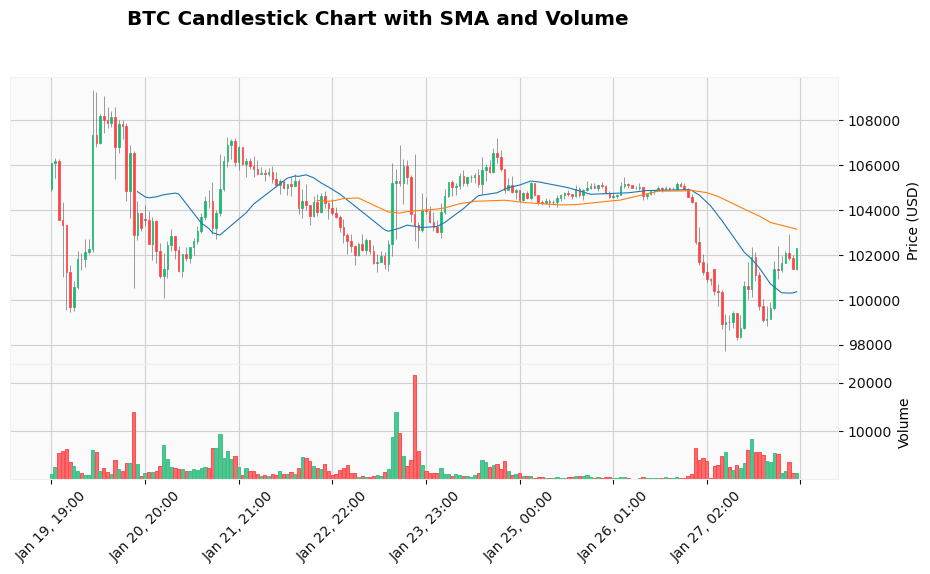

In [10]:
# Ensure required columns exist
df['date'] = df['utc_dt']  # or 'nyc_dt' for local time
ohlc_data = df[['utc_dt', 'open', 'high', 'low', 'close', 'volumefrom']].rename(columns={
    'utc_dt': 'date',  # Ensure column for the index is named 'date'
    'volumefrom': 'volume'  # Rename volume column
}).set_index('date')

# Plot with SMA and Bollinger Bands
mpf.plot(
    ohlc_data[-200:],  # Last 100 hours for clarity
    type='candle',
    mav=(24, 72),  # SMA lines
    volume=True,
    style='yahoo',
    title='BTC Candlestick Chart with SMA and Volume',
    ylabel='Price (USD)',
    ylabel_lower='Volume',
    figratio=(18,9)
)


2.2 Visualization of RSI and MACD

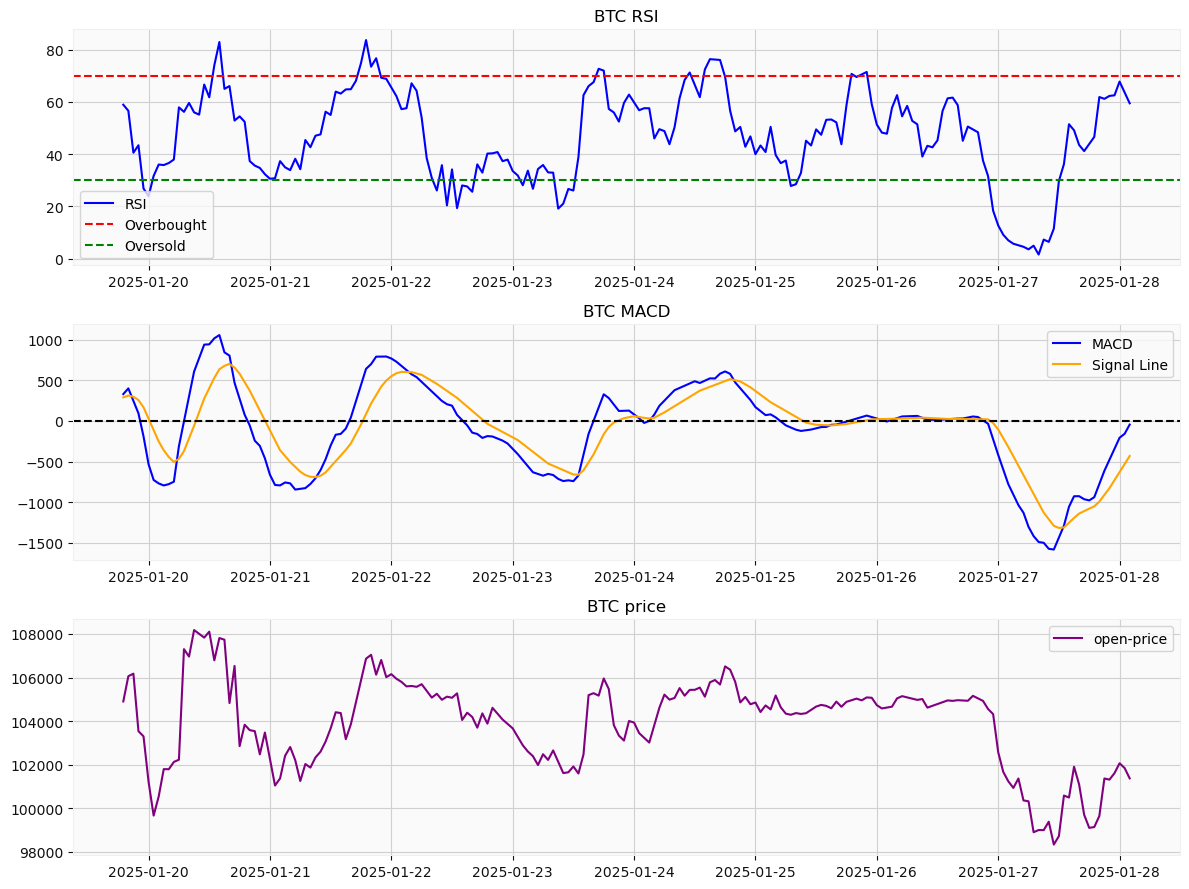

In [12]:
plt_df = df[-200:]

# Plot RSI
plt.figure(figsize=(12, 9))
plt.subplot(3, 1, 1)
plt.plot(plt_df['utc_dt'], plt_df['rsi'], label='RSI', color='blue')
plt.axhline(70, color='red', linestyle='--', label='Overbought')
plt.axhline(30, color='green', linestyle='--', label='Oversold')
plt.title('BTC RSI')
plt.legend()

# Plot MACD
plt.subplot(3, 1, 2)
plt.plot(plt_df['utc_dt'], plt_df['macd'], label='MACD', color='blue')
plt.plot(plt_df['utc_dt'], plt_df['macd_signal'], label='Signal Line', color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.title('BTC MACD')
plt.legend()

# plot price
plt.subplot(3, 1, 3)
plt.plot(plt_df['utc_dt'], plt_df['open'], label='open-price', color='purple')
plt.title('BTC price')
plt.legend()

plt.tight_layout()
plt.show()


2.3 Visualization of Bollinger Bands

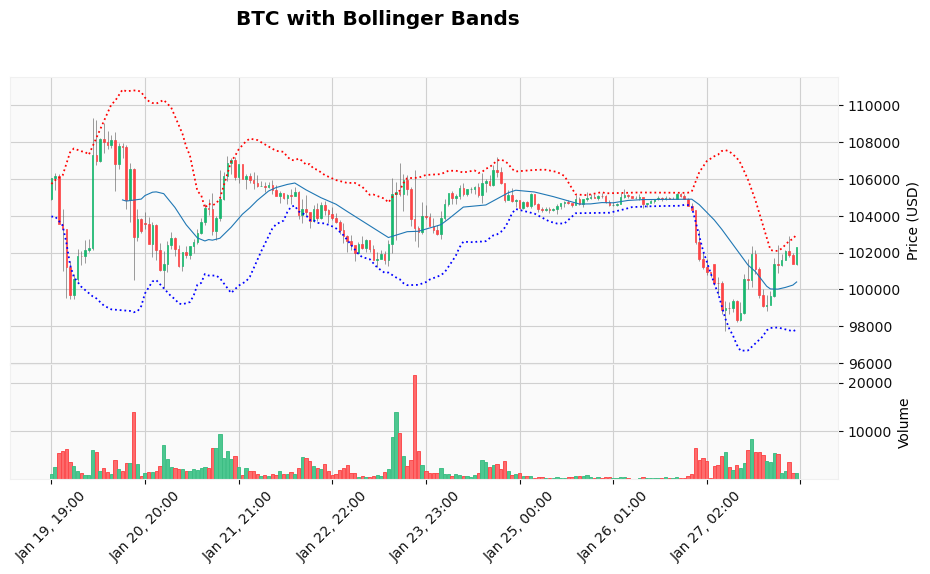

In [13]:
df['date'] = df['utc_dt']  # or 'nyc_dt' for local time
ohlc_data = df.rename(columns={
    'volumefrom': 'volume'  # Rename volume column
}).set_index('date')

mpf.plot(
    ohlc_data[-200:],  # Last 100 rows
    type='candle',
    style='yahoo',
    mav=(20),  # Middle Band (20-period SMA)
    volume=True,
    addplot=[
        mpf.make_addplot(ohlc_data['bollinger_upper'][-200:], color='red', linestyle='dotted'),
        mpf.make_addplot(ohlc_data['bollinger_lower'][-200:], color='blue', linestyle='dotted'),
    ],
    title='BTC with Bollinger Bands',
    ylabel='Price (USD)',
    ylabel_lower='Volume',
    figratio=(18,9)
)

#### 3. Validate trading signals of each metric

In [53]:
def backtest_strategy(df):
    """
    Backtest a simple RSI and MACD-based strategy.

    Args:
        df (pd.DataFrame): DataFrame with columns `rsi`, `macd`, `macd_signal`, and `close`.

    Returns:
        trades (list): List of executed trades.
        total_pnl (float): Total profit and loss (PnL).
    """
    trades = []  # Store executed trades
    position = None  # Current position ('buy' or 'sell')
    entry_price = 0  # Price at which the position was entered
    total_pnl = 0  # Accumulated profit and loss

    for i in range(1, len(df)):
        # Extract necessary data
        rsi = df.iloc[i]['rsi']
        macd = df.iloc[i]['macd']
        macd_signal = df.iloc[i]['macd_signal']
        close = df.iloc[i]['close']

        # Check for buy condition
        if position is None and rsi < 30 and macd > macd_signal:
            position = 'buy'
            entry_price = close
            trades.append({'action': 'buy', 'price': entry_price, 'date': df.iloc[i]['utc_dt']})

        # Check for sell condition
        elif position == 'buy' and rsi > 70 and macd < macd_signal:
            pnl = close - entry_price  # Profit or loss
            total_pnl += pnl
            trades.append({'action': 'sell', 'price': close, 'date': df.iloc[i]['utc_dt'], 'pnl': pnl})
            position = None  # Reset position

    return trades, total_pnl

# Example usage:
filter = (df['utc_dt']>='2024-1-01')&(df['utc_dt']<='2024-12-31')
trades, total_pnl = backtest_strategy(df[filter])
print(f"Total PnL: {total_pnl}")
for trade in trades:
    print(trade)


Total PnL: -3237.030000000006
{'action': 'buy', 'price': 69238.14, 'date': Timestamp('2024-04-10 01:00:00+0000', tz='UTC')}
{'action': 'sell', 'price': 64344.61, 'date': Timestamp('2024-04-19 19:00:00+0000', tz='UTC'), 'pnl': -4893.529999999999}
{'action': 'buy', 'price': 61234.68, 'date': Timestamp('2024-05-09 07:00:00+0000', tz='UTC')}
{'action': 'sell', 'price': 65833.5, 'date': Timestamp('2024-05-16 04:00:00+0000', tz='UTC'), 'pnl': 4598.82}
{'action': 'buy', 'price': 67716.29, 'date': Timestamp('2024-05-24 01:00:00+0000', tz='UTC')}
{'action': 'sell', 'price': 62645.04, 'date': Timestamp('2024-07-15 12:00:00+0000', tz='UTC'), 'pnl': -5071.249999999993}
{'action': 'buy', 'price': 65861.35, 'date': Timestamp('2024-07-24 04:00:00+0000', tz='UTC')}
{'action': 'sell', 'price': 60915.41, 'date': Timestamp('2024-08-20 13:00:00+0000', tz='UTC'), 'pnl': -4945.940000000002}
{'action': 'buy', 'price': 56605.17, 'date': Timestamp('2024-09-04 12:00:00+0000', tz='UTC')}
{'action': 'sell', 'pric